In [1]:
import os
import random
import numpy as np
import torch

SEED_VALUE = 0
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)

In [2]:
import datetime
def timestamp():
    time_cur = datetime.datetime.now()
    print("datetime : ", time_cur.strftime("%m/%d/%H:%M%S"))
    stamp = time_cur.strftime("%m%d%H%M%S")
    return stamp

stamp = timestamp()
print(stamp)

datetime :  07/26/04:3412
0726043412


In [3]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_gformat = "retina"
%matplotlib inline

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
def plot_scatter_with_error(y, pred_y, pred_std):
    plt.errorbar(y, pred_y, yerr= pred_std, fmt='o', markersize=10, ecolor="black", markeredgecolor ="black",color="b")
    y_max = max(y.max(), (pred_y + pred_std).max())
    y_min = min(y.min(), (pred_y - pred_std).min())
    plt.plot([y_min - 0.05*(y_max - y_min),y_max + 0.05*(y_max - y_min)],
            [y_min - 0.05*(y_max - y_min),y_max + 0.05*(y_max - y_min)], "k-")
    plt.xlim(y_min - 0.05*(y_max - y_min),y_max + 0.05*(y_max - y_min))
    plt.ylim(y_min - 0.05*(y_max - y_min),y_max + 0.05*(y_max - y_min))
    plt.xlabel("actual y")
    plt.ylabel("estimated_y")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.show()

def draw_scatter(y, y_pred):
    plt.rcParams["font.size"] = 18
    plt.scatter(y, y_pred, c="blue")
    y_max = max(y.max(), y_pred.max())
    y_min = min(y.min(), y_pred.min())
    plt.plot([y_min - 0.05*(y_max - y_min),y_max + 0.05*(y_max - y_min)],
            [y_min - 0.05*(y_max - y_min),y_max + 0.05*(y_max - y_min)], "k-")
    plt.xlim(y_min - 0.05*(y_max - y_min),y_max + 0.05*(y_max - y_min))
    plt.ylim(y_min - 0.05*(y_max - y_min),y_max + 0.05*(y_max - y_min))
    plt.xlabel("actual y")
    plt.ylabel("estimated y")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.show()  
    
def mean_absolute_percentage_error(y, y_pred):
    return np.mean(np.abs((y - y_pred)/y_pred))*100

def score(y, y_pred):
    print(f"r2:{r2_score(y, y_pred):.3}")
    print(f"RMSE:{mean_squared_error(y, y_pred, squared=False):.3}")
    print(f"MAE:{mean_absolute_error(y, y_pred):.3}")
    try:
        print(f"MAPE:{mean_absolute_percentage_error(y, y_pred):.3}")
    except:
        pass

In [ ]:
import pandas as pd


x_train = pd.read_csv("data/x_train.csv", index_col=0)
x_test = pd.read_csv("data/x_test.csv", index_col=0)

y_train = pd.read_csv("data/y_train.csv", index_col=0)
y_test = pd.read_csv("data/y_test.csv", index_col=0)

In [5]:
x_train_add = x_test.iloc[200:,:]
x_test = x_test.iloc[:200,:]
x_test_name = x_test.index.to_list()
x_name = x_train.columns.to_list()

y_train_add = y_test.iloc[200:,:]
y_test = y_test.iloc[:200,:]

x_train = pd.concat([x_train, x_train_add],axis=0)
y_train = pd.concat([y_train, y_train_add],axis=0)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(928, 55) (200, 55)
(928, 1) (200, 1)


In [6]:
y_test

,measured log solubility in mols per litre
Compound ID,
"2,4-Dimethyl-2-pentanol",-0.920
rhodanine,-1.770
Bromoethane,-1.090
Chloropham,-3.380
Diethyl sulfide,-1.340
...,...
"1,4-Dibromobenzene",-4.070
Prasterone,-4.120
Propyne,-0.410


In [7]:
x_train_mean = x_train.mean()
x_train_std = x_train.std(ddof=1)
autoscaled_x_train = (x_train - x_train_mean)/x_train_std
autoscaled_x_test = (x_test - x_train_mean)/x_train_std

y_train_mean = y_train.mean()
y_train_std = y_train.std(ddof=1)
autoscaled_y_train = (y_train - y_train_mean)/y_train_std

In [8]:
autoscaled_x_train = torch.from_numpy(autoscaled_x_train.values.astype(np.float32))
autoscaled_x_test = torch.from_numpy(autoscaled_x_test.values.astype(np.float32))

autoscaled_y_train = torch.from_numpy(autoscaled_y_train.values.astype(np.float32)).reshape(-1,)

In [9]:
import gpytorch
from gpytorch.models import ExactGP

In [ ]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(autoscaled_x_train, autoscaled_y_train, likelihood)

100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 67.53it/s]


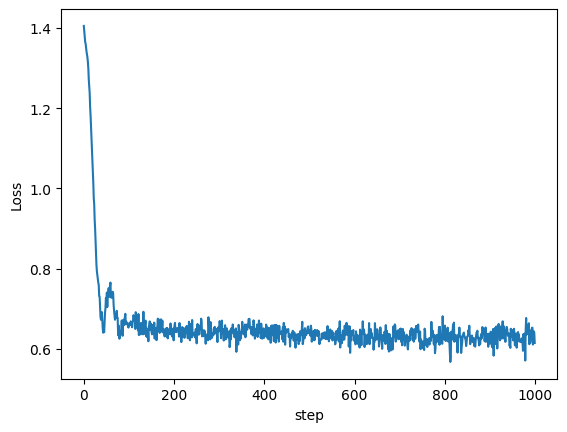

In [ ]:
from tqdm import tqdm

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1) 

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 1000
loss_list = []
for i in tqdm(range(training_iter)):
    optimizer.zero_grad()
    output = model(autoscaled_x_train)
    loss = -mll(output, autoscaled_y_train)
    loss.backward()
    optimizer.step()
    loss_list.append(loss.cpu().detach().numpy())

plt.plot(loss_list)
plt.xlabel('step')
plt.ylabel('Loss');

In [12]:
# 推論モードに設定
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    
    # 予測分布の出力
    autoscaled_y_pred = likelihood(model(autoscaled_x_test))

r2:0.868
RMSE:0.791
MAE:0.582


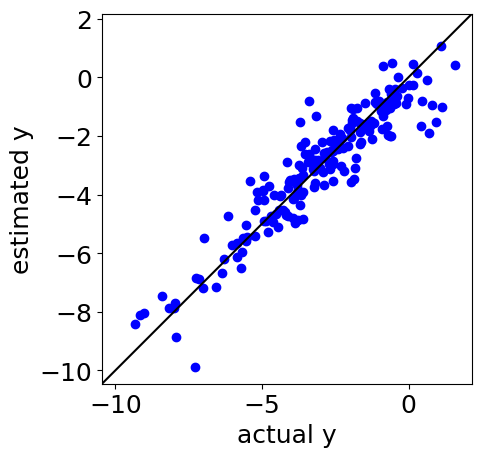

In [13]:
y_pred = autoscaled_y_pred.mean.cpu().numpy() * y_train_std.values + y_train_mean.values
y_pred_std = autoscaled_y_pred.stddev.cpu().numpy() * y_train_std.values
score(y_test, y_pred)
draw_scatter(y_test.values, y_pred)

In [ ]:
def confidence_curve(y_true, y_pred, sigma):
    errors = np.abs(y_true - y_pred)
    sorted_indices = np.argsort(sigma)
    sorted_errors = errors[sorted_indices]
    fractions = np.linspace(0, 1, len(y_true)+1) # modified
    confidence_errors = [np.mean(sorted_errors[:int(f * len(sorted_errors))]) for f in fractions]
    return fractions, confidence_errors[::-1]

def oracle_curve(y_true, y_pred):
    errors = np.abs(y_true - y_pred)
    sorted_errors = np.sort(errors)
    fractions = np.linspace(0, 1, len(y_true+1)) # modified
    oracle_errors = [np.mean(sorted_errors[:int(f * len(sorted_errors))]) for f in fractions]
    return fractions, oracle_errors[::-1]

fractions, confidence_errors = confidence_curve(y_test.values.reshape(-1,), y_pred, f_std)
_, oracle_errors = oracle_curve(y_test.values.reshape(-1,), y_pred)

def calculate_auco(confidence_errors, oracle_errors):
    differences = np.abs(np.array(confidence_errors) - np.array(oracle_errors))

    return np.mean(differences[:-1])


auco = calculate_auco(fractions, confidence_errors, oracle_errors)
print(f'Area Under the Confidence-Oracle Curve (AUCO): {auco}')

plt.rcParams["font.size"] = 24
plt.figure(figsize=(9, 9))
plt.plot(fractions, confidence_errors, label='Confidence Curve', marker='o')
plt.plot(fractions, oracle_errors, label='Oracle Curve', linestyle='--')
plt.ylim(-0.05, 0.9)
plt.xlim(-0.05, 1.05)  
plt.xlabel('Fraction of removed data', fontsize=36)
plt.ylabel('Mean Absolute Error', fontsize=36)
plt.legend(loc='lower left')
plt.show()

In [15]:
model_info_dict = {}
model_info_dict["test_index"] = x_test_name
model_info_dict["y_pred_mean"] = y_pred
model_info_dict["y_pred_std"] = y_pred_std
model_info_dict["loss"] = loss_list

In [16]:
model_path = 'model'
os.makedirs(model_path, exist_ok=True)

In [17]:
model.state_dict()
torch.save(model.state_dict(), f'{model_path}/model_state_large_{stamp}.pth')

In [18]:
def prepare_for_grad(x, delta=1e-3):
    
    """
    Args:
        x : input(n,)
        delta : small amount
        
    Return:
        prepare_for_grad_x) : data for calculate grads (2n, n)
    """
    
    x_for_grad_list = []
    
    for i in range(x.shape[0]):
        tmp = torch.vstack((x, x))
        tmp[0,i] += delta
        tmp[1,i] -= delta
        x_for_grad_list.append(tmp)
        
    prepare_for_grad_x = torch.cat(x_for_grad_list, dim=0)
        
    assert x.shape[0]*2 == prepare_for_grad_x.shape[0], f'{x.shape[0]*2}→{prepare_for_grad_x.shape[0]}'
    
    return prepare_for_grad_x

In [19]:
def calc_grad(y, x):
    
    """
    Args:
        y : target variables (2n,)
        x : input varibales (2n, n)

    Return:
        grad : (n)
    """
    grad_list = []
    
    for i in range(x.shape[1]):
        grad = (y[2*i] - y[2*i+1])/(x[2*i, i] - x[2*i+1, i])
        grad_list.append(grad)
        
    assert x.shape[1] == torch.tensor(grad_list).shape[0], f'{x.shape[1]}→{torch.tensor(grad_list).shape[0]}'
        
    return torch.tensor(grad_list)

In [ ]:
def IG_torch(model, x, N=100):
    
    """
    Args:
        model : trained gaussian process model
        x : input varibales (1, n)
        N : the number of steps for calculate integrated gradients

    Return:
        IG : integrated gradients
    """
    
    IG_tmp = []
    
    for n in range(N+1): 
        x_n = x * n/N
        x_n = x_n.detach().clone().requires_grad_(True)  
        f_preds = model(x_n.reshape(1,-1))
        f_preds_mean = f_preds.mean
        f_preds_mean.backward()
        IG_tmp.append(x_n.grad.clone())
    
    IG_tmp = torch.stack(IG_tmp, dim=0)
    IG = torch.mean(IG_tmp, dim=0).detach()
    
    return IG

In [ ]:
def GP_IG(model, x, N=100, sampling=100):
    
    """
    Args:
        model : trained gaussian process model
        x : input varibales (n)
        N : the number of steps for calculate integrated gradients
        samping : the number of functions sampled from model

    Return:
        all_IG : calculated all integrated gradients
    """
    
    for s in range(sampling):
        
        for n in range(N+1):
            x_n = x * n/N
            x_n_for_grad = prepare_for_grad(x_n)
            
            if n == 0:
                all_x_n_for_grad = x_n_for_grad.detach().clone()
            else:
                all_x_n_for_grad = torch.vstack((all_x_n_for_grad, x_n_for_grad))
                
        assert all_x_n_for_grad.cpu().numpy().shape == (x.shape[0]*2*(N+1) , x.shape[0]), f"{all_x_n_for_grad.numpy().shape}→{(x.shape[0]*2*(N+1) , x.shape[0])}"
        
        all_y_sampling_for_grad = model(all_x_n_for_grad).sample()
        
        for n2 in range(N+1):
            
            y_sampling_for_grad = all_y_sampling_for_grad[n2*x.shape[0]*2:((n2+1)*x.shape[0]*2)]
            x_n_for_grad = all_x_n_for_grad[n2*x.shape[0]*2:((n2+1)*x.shape[0]*2),:]

            grad = calc_grad(y_sampling_for_grad, x_n_for_grad).detach()
            
            if n2 == 0:
                all_grad = grad.detach().clone()
            else:
                all_grad = torch.vstack((all_grad, grad))

        IG = all_grad.mean(axis=0).detach()
        
        if s == 0:
            all_IG = IG.detach().clone()
        else:
            all_IG = torch.vstack((all_IG, IG))
        
    assert all_IG.cpu().numpy().shape == (sampling, x.shape[0]), f"{all_IG.numpy().shape }→{(sampling, x.shape[0])}"
    
    return all_IG

In [22]:
results_path = f'results/results_{stamp}'
os.makedirs(results_path, exist_ok=True)

In [23]:
import joblib
joblib.dump(model_info_dict, f'{results_path}/model_info_{stamp}.pkl')

['results/results_0726043412/model_info_0726043412.pkl']

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Jul 26 2024

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.34.0

pandas    : 1.5.1
numpy     : 1.24.4
joblib    : 1.3.2
gpytorch  : 1.11
matplotlib: 3.6.0
torch     : 1.13.0

Watermark: 2.4.3



In [ ]:
for i in tqdm(range(100)):
    
    save_dic = {}
    
    autoscaled_x_test_n = autoscaled_x_test[i,:]
    
    f_preds = model(autoscaled_x_test_n.reshape(1,-1))
    autoscaled_y_pred_mean = f_preds.mean
    autoscaled_y_pred_var = f_preds.variance
    y_pred_mean = autoscaled_y_pred_mean.cpu().detach().numpy() * y_train_std + y_train_mean
    y_pred_var = autoscaled_y_pred_var.cpu().detach().numpy() * y_train_std * y_train_std 
    
    
    GP_IG_results = GP_IG(model, autoscaled_x_test_n, sampling=1000)
    IG_results = IG_torch(model, autoscaled_x_test_n)
    
    save_dic["test_index"] = x_test_name[i]
    save_dic["x"] = autoscaled_x_test_n
    save_dic["x_name"] = x_name
    
    save_dic["y"] = y_test.iloc[i]
    save_dic["y_train_mean"] = y_train_mean
    save_dic["y_train_std"] = y_train_std
    save_dic["y_pred_mean"] = y_pred_mean
    save_dic["y_pred_var"] = y_pred_var
    
    save_dic["GP_IG"] = GP_IG_results
    
    save_dic["IG"] = IG_results
    
    #import joblib
    joblib.dump(save_dic, f'{results_path}/interpret_results_{x_test_name[i]}_{stamp}.pkl')

  3%|█                                  | 3/100 [3:16:34<106:45:35, 3962.22s/it]